# Halofit Emulation
Author: João Victor Rebouças, May 2023

In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import keras
import hyperopt
import train_utils as utils
from train_utils import params, lims, ref
# Don't worry about tensorflow warnings

2023-05-23 15:56:14.559152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 15:56:14.583983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train redshifts
redshifts = [0, 0.5, 1.0, 2.0, 3.0]

### 1. Data preprocessing
**How to use**: select the desired dataset in `path_to_train` and run all subsequent cells until the [training section](#Training).

**Pipeline description**:
- Load chosen training data
- Smear BAO in linear $P(k)$ (using BACCO's code)
- Calculate $Q(k) = \log(P_\mathrm{NL}/P_\mathrm{lin,\, smear})$
- Normalize cosmological parameters based on EE2 box boundaries
- Normalize $Q$ using min-max
- Save $Q$ normalization parameters (for rescaling $Q$ after emulation)
- PCA
- Normalize PCs using min-max
- Save PC normalization parameters

In [3]:
# Data can be downloaded at https://github.com/SBU-Jonathan/halofit_data
# LCDM datasets
path_to_spectra = "/home/grads/data/jonathan/halofit_data/"
path_to_train400_0percent = path_to_spectra + "lcdm/0_percent/400"
path_to_train400_10percent = path_to_spectra + "lcdm/10_percent/400"
path_to_train400_20percent = path_to_spectra + "lcdm/20_percent/400"
path_to_train800_0percent = path_to_spectra + "lcdm/0_percent/800"
path_to_train800_10percent = path_to_spectra + "lcdm/10_percent/800"
path_to_train800_20percent = path_to_spectra + "lcdm/20_percent/800"

# wCDM datasets
path_to_train500_0percent = path_to_spectra + "wcdm/0_percent/500"
path_to_train500_10percent = path_to_spectra + "wcdm/10_percent/500"
path_to_train500_20percent = path_to_spectra + "wcdm/20_percent/500"
path_to_train1000_0percent = path_to_spectra + "wcdm/0_percent/1000"
path_to_train1000_10percent = path_to_spectra + "wcdm/10_percent/1000"
path_to_train1000_20percent = path_to_spectra + "wcdm/20_percent/1000"

In [4]:
# Select which training dataset to use
path_to_train = path_to_train500_10percent

In [5]:
# Load training LHS
train_samples = np.loadtxt(f"{path_to_train}/lhs.txt")
print(train_samples[0])

[ 2.53339036e-01  5.06046123e-02  9.43347267e-01  1.79558404e-09
  6.55155732e-01 -6.76464863e-01]


In [6]:
# Load ref cosmology from CAMB, all redshifts
pk_lin_ref = np.zeros((len(redshifts), len(utils.ks_400)))
pk_nl_ref = np.zeros((len(redshifts), len(utils.ks_400)))
pk_lin_smear_ref = np.zeros((len(redshifts), len(utils.ks_400)))
for i, redshift in enumerate(redshifts):
    ks, pk_lin_ref[i], pk_nl_ref[i] = np.loadtxt(f"{path_to_train}/pk_ref_z_{redshift:.3f}.txt", unpack=True)
    pk_lin_smear_ref[i] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pk_lin_ref[i], k_emu=ks, pk_lin_emu=pk_lin_ref[i])
ref_boost = pk_nl_ref/pk_lin_ref
ref_expq = pk_nl_ref/pk_lin_smear_ref

In [7]:
# Load training data
pks_lin_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
pks_lin_smear_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
pks_nl_train = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))

for i in range(len(train_samples)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_train[i,j], pks_nl_train[i,j] = np.loadtxt(f"{path_to_train}/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_train[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_train[i,j], k_emu=ks, pk_lin_emu=pks_lin_train[i,j])

In [8]:
# Defining emulated quantities
train_logboosts = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
train_qs = np.zeros((len(train_samples), len(redshifts), len(utils.ks_400)))
for i in range(len(train_samples)):
    r_nl = pks_nl_train[i]/pk_nl_ref
    r_lin = pks_lin_train[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_train[i]/pk_lin_smear_ref
    train_logboosts[i] = np.log(ref_boost * r_nl / r_lin)
    train_qs[i] = np.log(ref_expq * r_nl / r_lin_smear)

In [9]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples), len(train_samples[0])))
for i, train_point in enumerate(train_samples):
    train_sample_norm[i] = utils.normalize_params(train_point)

In [10]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
    train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift

In [11]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i in range(len(redshifts)):
    mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
    maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
    mins_qs[i] = np.amin(train_qs[:,i,:])
    maxs_qs[i] = np.amax(train_qs[:,i,:])

In [12]:
# PCA reduction
num_pcs = 11
pcas_logboosts, train_logboosts_pcs = utils.pca_reduction(num_pcs, train_logboosts_norm, redshifts)
pcas_qs, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts)

In [13]:
# Normalizing PCs
train_logboosts_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
train_qs_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    train_logboosts_pcs_norm[:,i] = utils.normalize_array(train_logboosts_pcs[:,i]) # I normalize within each redshift
    train_qs_pcs_norm[:,i] = utils.normalize_array(train_qs_pcs[:,i]) # I normalize within each redshift

# Saving mins and maxs for rescaling
mins_logboosts_pcs = np.zeros((len(redshifts)))
maxs_logboosts_pcs = np.zeros((len(redshifts)))
mins_qs_pcs = np.zeros((len(redshifts)))
maxs_qs_pcs = np.zeros((len(redshifts)))
for i in range(len(redshifts)):
        mins_logboosts_pcs[i] = np.amin(train_logboosts_pcs[:,i])
        maxs_logboosts_pcs[i] = np.amax(train_logboosts_pcs[:,i])
        mins_qs_pcs[i] = np.amin(train_qs_pcs[:,i])
        maxs_qs_pcs[i] = np.amax(train_qs_pcs[:,i])

In [76]:
# Normalizing PCs
train_logboosts_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
train_qs_pcs_norm = np.zeros((len(train_samples), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    for j in range(num_pcs):
        train_logboosts_pcs_norm[:,i,j] = utils.normalize_array(train_logboosts_pcs[:,i,j]) # I normalize within each redshift
        train_qs_pcs_norm[:,i,j] = utils.normalize_array(train_qs_pcs[:,i,j]) # I normalize within each redshift

# Saving mins and maxs for rescaling
mins_logboosts_pcs = np.zeros((len(redshifts), num_pcs))
maxs_logboosts_pcs = np.zeros((len(redshifts), num_pcs))
mins_qs_pcs = np.zeros((len(redshifts), num_pcs))
maxs_qs_pcs = np.zeros((len(redshifts), num_pcs))
for i in range(len(redshifts)):
    for j in range(num_pcs):
        mins_logboosts_pcs[i,j] = np.amin(train_logboosts_pcs[:,i,j])
        maxs_logboosts_pcs[i,j] = np.amax(train_logboosts_pcs[:,i,j])
        mins_qs_pcs[i,j] = np.amin(train_qs_pcs[:,i,j])
        maxs_qs_pcs[i,j] = np.amax(train_qs_pcs[:,i,j])

### Training
**How to use**: 
- **Must have run data preprocessing section with the desired dataset**
- Define your model using the `utils.generate_resnet` or `utils.generate_mlp` functions.
- Train the model using the `utils.nn_model_train` function, where you can choose to train on `logboosts` or smeared boosts.
- Save your model using `model.save("path")`.
- See cells below for examples on training individual models at $z = 0$ and how to sequentially train models on all redshifts.

In [80]:
# Generate resnet model
resnet = utils.generate_resnet(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_res_blocks=1,
    num_of_neurons=1024,
    activation="relu",
    alpha=1e-4,
    l1_ratio=0.1,
    dropout=0
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 dense_51 (Dense)               (None, 1024)         6144        ['input_14[0][0]']               
                                                                                                  
 dense_52 (Dense)               (None, 1024)         1049600     ['dense_51[0][0]']               
                                                                                                  
 add_19 (Add)                   (None, 1024)         0           ['dense_51[0][0]',               
                                                                  'dense_52[0][0]']        

In [17]:
# Generate MLP model
mlp = utils.generate_mlp(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_layers=2,
    num_of_neurons=1024,
    alpha=1e-4,
    l1_ratio=0.1,
    dropout=0
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer_1 (Dense)         (None, 1024)              7168      
                                                                 
 hid_layer_2 (Dense)         (None, 1024)              1049600   
                                                                 
 out_layer (Dense)           (None, 6)                 6150      
                                                                 
Total params: 1,062,918
Trainable params: 1,062,918
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Training (z=0) for 2.6k epochs. Starting from epoch 1500, the learning rate halves every 200 epochs
start = perf_counter()
last_loss = utils.nn_model_train(resnet, 1600, train_sample_norm, train_qs_pcs_norm[:,0], decayevery=1500, decayrate=2)
last_loss = utils.nn_model_train(resnet, 1000, train_sample_norm, train_qs_pcs_norm[:,0], decayevery=200, decayrate=2)
print(f"Training took {perf_counter() - start} seconds")

Epoch 1/1600
14/14 [==============================] - 1s 5ms/step - loss: 0.5734 - lr: 0.0010
Epoch 2/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.4070 - lr: 0.0010
Epoch 3/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.3205 - lr: 0.0010
Epoch 4/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.2637 - lr: 0.0010
Epoch 5/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.2067 - lr: 0.0010
Epoch 6/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.1802 - lr: 0.0010
Epoch 7/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.1617 - lr: 0.0010
Epoch 8/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.1455 - lr: 0.0010
Epoch 9/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.1357 - lr: 0.0010
Epoch 10/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.1269 - lr: 0.0010
Epoch 11/1600
14/14 [==============================] - 0s 5

14/14 [==============================] - 0s 5ms/step - loss: 0.0565 - lr: 0.0010
Epoch 88/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0553 - lr: 0.0010
Epoch 89/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0554 - lr: 0.0010
Epoch 90/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0558 - lr: 0.0010
Epoch 91/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0541 - lr: 0.0010
Epoch 92/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0540 - lr: 0.0010
Epoch 93/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0505 - lr: 0.0010
Epoch 94/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0339 - lr: 0.0010
Epoch 95/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0291 - lr: 0.0010
Epoch 96/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0268 - lr: 0.0010
Epoch 97/1600
14/14 [==============================] - 0s 5ms/st

14/14 [==============================] - 0s 5ms/step - loss: 0.0162 - lr: 0.0010
Epoch 173/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0164 - lr: 0.0010
Epoch 174/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0160 - lr: 0.0010
Epoch 175/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0164 - lr: 0.0010
Epoch 176/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0168 - lr: 0.0010
Epoch 177/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0172 - lr: 0.0010
Epoch 178/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0184 - lr: 0.0010
Epoch 179/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0189 - lr: 0.0010
Epoch 180/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0175 - lr: 0.0010
Epoch 181/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0165 - lr: 0.0010
Epoch 182/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0145 - lr: 0.0010
Epoch 258/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0147 - lr: 0.0010
Epoch 259/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0143 - lr: 0.0010
Epoch 260/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0142 - lr: 0.0010
Epoch 261/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0142 - lr: 0.0010
Epoch 262/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0140 - lr: 0.0010
Epoch 263/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0155 - lr: 0.0010
Epoch 264/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0148 - lr: 0.0010
Epoch 265/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0148 - lr: 0.0010
Epoch 266/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0147 - lr: 0.0010
Epoch 267/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0132 - lr: 0.0010
Epoch 343/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0129 - lr: 0.0010
Epoch 344/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0135 - lr: 0.0010
Epoch 345/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0133 - lr: 0.0010
Epoch 346/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0141 - lr: 0.0010
Epoch 347/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0139 - lr: 0.0010
Epoch 348/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0137 - lr: 0.0010
Epoch 349/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0144 - lr: 0.0010
Epoch 350/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0137 - lr: 0.0010
Epoch 351/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0135 - lr: 0.0010
Epoch 352/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0136 - lr: 0.0010
Epoch 428/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0139 - lr: 0.0010
Epoch 429/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0128 - lr: 0.0010
Epoch 430/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0132 - lr: 0.0010
Epoch 431/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0132 - lr: 0.0010
Epoch 432/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0125 - lr: 0.0010
Epoch 433/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0138 - lr: 0.0010
Epoch 434/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0133 - lr: 0.0010
Epoch 435/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0125 - lr: 0.0010
Epoch 436/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0128 - lr: 0.0010
Epoch 437/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0115 - lr: 0.0010
Epoch 513/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0121 - lr: 0.0010
Epoch 514/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0118 - lr: 0.0010
Epoch 515/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0118 - lr: 0.0010
Epoch 516/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0121 - lr: 0.0010
Epoch 517/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0126 - lr: 0.0010
Epoch 518/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0123 - lr: 0.0010
Epoch 519/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0127 - lr: 0.0010
Epoch 520/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0123 - lr: 0.0010
Epoch 521/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0129 - lr: 0.0010
Epoch 522/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0113 - lr: 0.0010
Epoch 598/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0113 - lr: 0.0010
Epoch 599/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0111 - lr: 0.0010
Epoch 600/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0114 - lr: 0.0010
Epoch 601/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0111 - lr: 0.0010
Epoch 602/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0108 - lr: 0.0010
Epoch 603/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0114 - lr: 0.0010
Epoch 604/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0122 - lr: 0.0010
Epoch 605/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0122 - lr: 0.0010
Epoch 606/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0109 - lr: 0.0010
Epoch 607/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0108 - lr: 0.0010
Epoch 683/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 684/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0109 - lr: 0.0010
Epoch 685/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0111 - lr: 0.0010
Epoch 686/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0112 - lr: 0.0010
Epoch 687/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0118 - lr: 0.0010
Epoch 688/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0122 - lr: 0.0010
Epoch 689/1600
14/14 [==============================] - 0s 6ms/step - loss: 0.0124 - lr: 0.0010
Epoch 690/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0113 - lr: 0.0010
Epoch 691/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0111 - lr: 0.0010
Epoch 692/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0105 - lr: 0.0010
Epoch 768/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0112 - lr: 0.0010
Epoch 769/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0116 - lr: 0.0010
Epoch 770/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0111 - lr: 0.0010
Epoch 771/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0106 - lr: 0.0010
Epoch 772/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0110 - lr: 0.0010
Epoch 773/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 774/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 775/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0104 - lr: 0.0010
Epoch 776/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0115 - lr: 0.0010
Epoch 777/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 853/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0104 - lr: 0.0010
Epoch 854/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 855/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0104 - lr: 0.0010
Epoch 856/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 857/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 858/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 859/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0109 - lr: 0.0010
Epoch 860/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 861/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 862/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 938/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 939/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 940/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 941/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 942/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 943/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 944/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0107 - lr: 0.0010
Epoch 945/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 946/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 947/1600
14/14 [==============================] -

14/14 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 1023/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1024/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1025/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 1026/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0102 - lr: 0.0010
Epoch 1027/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 1028/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 1029/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1030/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 1031/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1032/1600
14/14 [=======================

14/14 [==============================] - 0s 6ms/step - loss: 0.0101 - lr: 0.0010
Epoch 1107/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 1108/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 1109/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1110/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1111/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1112/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1113/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 1114/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1115/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 1116/1600
14/14 [=======================

14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 1191/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1192/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 1193/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1194/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 1195/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 1196/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 1197/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 1198/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1199/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1200/1600
14/14 [=======================

14/14 [==============================] - 0s 5ms/step - loss: 0.0104 - lr: 0.0010
Epoch 1275/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1276/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 1277/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0089 - lr: 0.0010
Epoch 1278/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 1279/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1280/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1281/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0090 - lr: 0.0010
Epoch 1282/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0105 - lr: 0.0010
Epoch 1283/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0105 - lr: 0.0010
Epoch 1284/1600
14/14 [=======================

14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1359/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0090 - lr: 0.0010
Epoch 1360/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0091 - lr: 0.0010
Epoch 1361/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 1362/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 1363/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 1364/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1365/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0089 - lr: 0.0010
Epoch 1366/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 1367/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 1368/1600
14/14 [=======================

14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1443/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 1444/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0089 - lr: 0.0010
Epoch 1445/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 1446/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0099 - lr: 0.0010
Epoch 1447/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 1448/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0097 - lr: 0.0010
Epoch 1449/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 1450/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 1451/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 1452/1600
14/14 [=======================

14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 1526/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0066 - lr: 5.0000e-04
Epoch 1527/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 5.0000e-04
Epoch 1528/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 5.0000e-04
Epoch 1529/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 1530/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 5.0000e-04
Epoch 1531/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 1532/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 5.0000e-04
Epoch 1533/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 1534/1600
14/14 [==============================] - 0s 4ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 7/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 8/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 9/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 10/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 11/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0066 - lr: 5.0000e-04
Epoch 12/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 13/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 14/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 15/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 16/1000
14/14 [======

Epoch 89/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 90/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 91/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 92/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 93/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 94/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 95/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 96/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 97/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 98/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 99/1

14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 172/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 173/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 174/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 175/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 176/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0066 - lr: 5.0000e-04
Epoch 177/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0063 - lr: 5.0000e-04
Epoch 178/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 179/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 5.0000e-04
Epoch 180/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 5.0000e-04
Epoch 181/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 254/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 255/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 256/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 2.5000e-04
Epoch 257/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 258/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 259/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 260/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 261/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 262/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 263/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 336/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 2.5000e-04
Epoch 337/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 338/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 339/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 2.5000e-04
Epoch 340/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 341/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 342/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 2.5000e-04
Epoch 343/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 344/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 2.5000e-04
Epoch 345/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 418/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 419/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 420/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 421/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 422/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 423/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 424/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 425/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 426/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 427/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 500/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 501/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 502/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 503/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 504/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 1.2500e-04
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 1.2500e-04
Epoch 509/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 582/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 583/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 1.2500e-04
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 1.2500e-04
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 1.2500e-04
Epoch 591/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 671/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 672/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 673/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 6.2500e-05
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 750/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 6.2500e-05
Epoch 751/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 6.2500e-05
Epoch 752/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 6.2500e-05
Epoch 753/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 6.2500e-05
Epoch 754/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.0038 - lr: 6.2500e-05
Epoch 755/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 3.1250e-05
Epoch 828/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 829/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 830/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 831/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 832/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 833/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 834/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 835/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 836/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 837/1000


14/14 [==============================] - 0s 6ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 910/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 3.1250e-05
Epoch 911/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 912/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 913/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 3.1250e-05
Epoch 914/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 3.1250e-05
Epoch 915/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 916/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 917/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 918/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 919/1000


14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 992/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 993/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 994/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 995/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 996/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 997/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 998/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 999/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Epoch 1000/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 3.1250e-05
Training took 

In [31]:
resnet.save("models/wcdm/resnet_smear_11PCS_2blocks512")

INFO:tensorflow:Assets written to: models/wcdm/resnet_smear_11PCS_sigmoid/assets


INFO:tensorflow:Assets written to: models/wcdm/resnet_smear_11PCS_sigmoid/assets


In [14]:
# Automatically generate and save models for each redshift
for i, z in enumerate(redshifts):
    resnet = utils.generate_resnet(
        input_shape=len(train_samples[0]),
        output_shape=num_pcs,
        num_res_blocks=1,
        num_of_neurons=1024,
        alpha=1e-4,
        l1_ratio=0.1,
        dropout=0
    )
    
    print(f"Starting training for redshift {z:.2f}")
    start = perf_counter()
    # Notice that i'm passing the PCs for redshift i to the training
    truths = train_qs_pcs_norm[:,i]
    last_loss = utils.nn_model_train(resnet, 200, train_sample_norm, truths)
    
    while last_loss > 0.03:
        # Sometimes, the model can get stuck on bad local minima.
        # If this happens, restart training
        print("Stuck in a bad local minimum. Regenerating model")
        resnet = utils.generate_resnet(
            input_shape=len(train_samples[0]),
            output_shape=num_pcs,
            num_res_blocks=1,
            num_of_neurons=1024,
            alpha=1e-4,
            l1_ratio=0.1,
            dropout=0
        )
        last_loss = utils.nn_model_train(resnet, 200, train_sample_norm, truths)
    
    last_loss = utils.nn_model_train(resnet, 1300, train_sample_norm, truths, decayevery=1200, decayrate=2)
    
    last_loss = utils.nn_model_train(resnet, 1000, train_sample_norm, truths, decayevery=200, decayrate=2)
    print(f"Training took {perf_counter() - start} seconds")
    
    resnet.save(f"models/wcdm/RESNET_Z{z:.2f}_{len(train_samples)}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         7168        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 1024)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

17/17 [==============================] - 0s 5ms/step - loss: 0.0114 - lr: 0.0010
Epoch 71/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0120 - lr: 0.0010
Epoch 72/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0109 - lr: 0.0010
Epoch 73/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0118 - lr: 0.0010
Epoch 74/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 75/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0093 - lr: 0.0010
Epoch 76/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0096 - lr: 0.0010
Epoch 77/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0088 - lr: 0.0010
Epoch 78/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0103 - lr: 0.0010
Epoch 79/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0088 - lr: 0.0010
Epoch 80/200
17/17 [==============================] - 0s 5ms/step - loss:

17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 157/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0060 - lr: 0.0010
Epoch 158/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 159/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0074 - lr: 0.0010
Epoch 160/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 0.0010
Epoch 161/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 0.0010
Epoch 162/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0081 - lr: 0.0010
Epoch 163/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0075 - lr: 0.0010
Epoch 164/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0078 - lr: 0.0010
Epoch 165/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0078 - lr: 0.0010
Epoch 166/200
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - lr: 0.0010
Epoch 43/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0055 - lr: 0.0010
Epoch 44/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0060 - lr: 0.0010
Epoch 45/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 46/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 47/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 48/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 0.0010
Epoch 49/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0062 - lr: 0.0010
Epoch 50/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 51/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 52/1300
17/17 [==============================] - 0s 4ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 129/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 130/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0054 - lr: 0.0010
Epoch 131/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 132/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 133/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 134/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 135/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 136/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 137/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 0.0010
Epoch 138/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 214/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 215/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 216/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 217/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 218/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - lr: 0.0010
Epoch 219/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 220/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 221/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 222/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 223/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 299/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 300/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 301/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 302/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 303/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 304/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 305/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 306/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 307/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 308/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 384/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 385/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 386/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - lr: 0.0010
Epoch 387/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 388/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 389/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 390/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 391/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 392/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 393/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 469/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 470/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 471/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 472/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 473/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 474/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 475/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 476/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 477/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 478/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 554/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 555/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 556/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 557/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 558/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 559/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 560/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 561/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 562/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 563/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 639/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 640/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 641/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 642/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 643/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 644/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 645/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 646/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 647/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 648/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 724/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 725/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 726/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 727/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 728/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 729/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0037 - lr: 0.0010
Epoch 730/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 731/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 732/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 733/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 809/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 810/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 811/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 812/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 813/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 814/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 815/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 816/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 817/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 818/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 894/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 895/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 896/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 897/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 898/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0034 - lr: 0.0010
Epoch 899/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 900/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 901/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0031 - lr: 0.0010
Epoch 902/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 903/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 979/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 980/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 981/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 982/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 983/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 984/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 985/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 986/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 987/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 988/1300
17/17 [==============================] -

Epoch 1063/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1064/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1065/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1066/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1067/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1068/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1069/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1070/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1071/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1072/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1073/1300
17/17 [=======

17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1148/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1149/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1150/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1151/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1152/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1153/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1154/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 1155/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1156/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1157/1300
17/17 [=======================

17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1231/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 1232/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1233/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1234/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1235/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1236/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1237/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1238/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1239/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 12/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 13/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 14/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 15/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 16/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 17/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 18/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 19/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0021 - lr: 5.0000e-04
Epoch 20/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 21/1000
17/17 [===

Epoch 94/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 95/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 96/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 97/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 98/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 99/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 100/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 101/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 102/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 103/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 

Epoch 176/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 177/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 178/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 179/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 180/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 181/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 182/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 183/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 184/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 185/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04


Epoch 258/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 259/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 260/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 261/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 262/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 263/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 264/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 265/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 266/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 267/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04


Epoch 340/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 341/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0013 - lr: 2.5000e-04
Epoch 342/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 343/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 344/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 345/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 346/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 347/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 348/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 349/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04


17/17 [==============================] - 0s 5ms/step - loss: 7.7811e-04 - lr: 1.2500e-04
Epoch 422/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.0903e-04 - lr: 1.2500e-04
Epoch 423/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1583e-04 - lr: 1.2500e-04
Epoch 424/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.9356e-04 - lr: 1.2500e-04
Epoch 425/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.3468e-04 - lr: 1.2500e-04
Epoch 426/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.3335e-04 - lr: 1.2500e-04
Epoch 427/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1432e-04 - lr: 1.2500e-04
Epoch 428/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1523e-04 - lr: 1.2500e-04
Epoch 429/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.2102e-04 - lr: 1.2500e-04
Epoch 430/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1

Epoch 500/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.0981e-04 - lr: 1.2500e-04
Epoch 501/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1882e-04 - lr: 1.2500e-04
Epoch 502/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.5928e-04 - lr: 1.2500e-04
Epoch 503/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.3841e-04 - lr: 1.2500e-04
Epoch 504/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.3063e-04 - lr: 1.2500e-04
Epoch 505/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.1266e-04 - lr: 1.2500e-04
Epoch 506/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.4527e-04 - lr: 1.2500e-04
Epoch 507/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.0097e-04 - lr: 1.2500e-04
Epoch 508/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.9853e-04 - lr: 1.2500e-04
Epoch 509/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 8.2805e-04 - lr: 1.2500e-04
Epoch 579/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.9843e-04 - lr: 1.2500e-04
Epoch 580/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.0135e-04 - lr: 1.2500e-04
Epoch 581/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.2543e-04 - lr: 1.2500e-04
Epoch 582/1000
17/17 [==============================] - 0s 6ms/step - loss: 8.3918e-04 - lr: 1.2500e-04
Epoch 583/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.4262e-04 - lr: 1.2500e-04
Epoch 584/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.6274e-04 - lr: 1.2500e-04
Epoch 585/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.7946e-04 - lr: 1.2500e-04
Epoch 586/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.2834e-04 - lr: 1.2500e-04
Epoch 587/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.9

Epoch 657/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9104e-04 - lr: 6.2500e-05
Epoch 658/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.6505e-04 - lr: 6.2500e-05
Epoch 659/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9657e-04 - lr: 6.2500e-05
Epoch 660/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.8459e-04 - lr: 6.2500e-05
Epoch 661/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9153e-04 - lr: 6.2500e-05
Epoch 662/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7577e-04 - lr: 6.2500e-05
Epoch 663/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8242e-04 - lr: 6.2500e-05
Epoch 664/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7751e-04 - lr: 6.2500e-05
Epoch 665/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9329e-04 - lr: 6.2500e-05
Epoch 666/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 6.6663e-04 - lr: 6.2500e-05
Epoch 736/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8801e-04 - lr: 6.2500e-05
Epoch 737/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.0193e-04 - lr: 6.2500e-05
Epoch 738/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.0656e-04 - lr: 6.2500e-05
Epoch 739/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8618e-04 - lr: 6.2500e-05
Epoch 740/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8515e-04 - lr: 6.2500e-05
Epoch 741/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.1210e-04 - lr: 6.2500e-05
Epoch 742/1000
17/17 [==============================] - 0s 6ms/step - loss: 7.2415e-04 - lr: 6.2500e-05
Epoch 743/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.2188e-04 - lr: 6.2500e-05
Epoch 744/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9

Epoch 814/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0796e-04 - lr: 3.1250e-05
Epoch 815/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1177e-04 - lr: 3.1250e-05
Epoch 816/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1037e-04 - lr: 3.1250e-05
Epoch 817/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1025e-04 - lr: 3.1250e-05
Epoch 818/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1108e-04 - lr: 3.1250e-05
Epoch 819/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1948e-04 - lr: 3.1250e-05
Epoch 820/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1553e-04 - lr: 3.1250e-05
Epoch 821/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1412e-04 - lr: 3.1250e-05
Epoch 822/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0996e-04 - lr: 3.1250e-05
Epoch 823/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 4ms/step - loss: 6.0990e-04 - lr: 3.1250e-05
Epoch 893/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1165e-04 - lr: 3.1250e-05
Epoch 894/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1523e-04 - lr: 3.1250e-05
Epoch 895/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2266e-04 - lr: 3.1250e-05
Epoch 896/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2174e-04 - lr: 3.1250e-05
Epoch 897/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2168e-04 - lr: 3.1250e-05
Epoch 898/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1687e-04 - lr: 3.1250e-05
Epoch 899/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1536e-04 - lr: 3.1250e-05
Epoch 900/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1516e-04 - lr: 3.1250e-05
Epoch 901/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1

Epoch 971/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.3082e-04 - lr: 3.1250e-05
Epoch 972/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1247e-04 - lr: 3.1250e-05
Epoch 973/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1234e-04 - lr: 3.1250e-05
Epoch 974/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1030e-04 - lr: 3.1250e-05
Epoch 975/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1001e-04 - lr: 3.1250e-05
Epoch 976/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0389e-04 - lr: 3.1250e-05
Epoch 977/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0736e-04 - lr: 3.1250e-05
Epoch 978/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0702e-04 - lr: 3.1250e-05
Epoch 979/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0853e-04 - lr: 3.1250e-05
Epoch 980/1000
17/17 [==============================] - 0s 4ms/s

INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z0.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z0.00_500/assets


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 1024)         7168        ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1024)         1049600     ['dense_3[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 1024)         0           ['dense_3[0][0]',                
                                                                  'dense_4[0][0]']          

17/17 [==============================] - 0s 5ms/step - loss: 0.0083 - lr: 0.0010
Epoch 71/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0086 - lr: 0.0010
Epoch 72/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0090 - lr: 0.0010
Epoch 73/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0092 - lr: 0.0010
Epoch 74/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0085 - lr: 0.0010
Epoch 75/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0091 - lr: 0.0010
Epoch 76/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 77/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0094 - lr: 0.0010
Epoch 78/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0089 - lr: 0.0010
Epoch 79/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0078 - lr: 0.0010
Epoch 80/200
17/17 [==============================] - 0s 5ms/step - loss:

17/17 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 157/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0059 - lr: 0.0010
Epoch 158/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 159/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0054 - lr: 0.0010
Epoch 160/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0067 - lr: 0.0010
Epoch 161/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0063 - lr: 0.0010
Epoch 162/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - lr: 0.0010
Epoch 163/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0050 - lr: 0.0010
Epoch 164/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 165/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 166/200
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 4ms/step - loss: 0.0065 - lr: 0.0010
Epoch 43/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 44/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 45/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 46/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 47/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 48/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0046 - lr: 0.0010
Epoch 49/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - lr: 0.0010
Epoch 50/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0047 - lr: 0.0010
Epoch 51/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0057 - lr: 0.0010
Epoch 52/1300
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 4ms/step - loss: 0.0052 - lr: 0.0010
Epoch 129/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0051 - lr: 0.0010
Epoch 130/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 131/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0043 - lr: 0.0010
Epoch 132/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 133/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 134/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 135/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 136/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 137/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 138/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 214/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 215/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 216/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 217/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0053 - lr: 0.0010
Epoch 218/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 219/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 220/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 221/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 222/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 223/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 299/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 300/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 301/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 302/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 303/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 304/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 305/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 306/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 307/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0044 - lr: 0.0010
Epoch 308/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 384/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 385/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 386/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 387/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 388/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 389/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 390/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 391/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 392/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 393/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 469/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 470/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 471/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 472/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 473/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 474/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 475/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 476/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 477/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 478/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 554/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 555/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 556/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 557/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 558/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 559/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 560/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 561/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 562/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 563/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 639/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 640/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 641/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 642/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 643/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 644/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 645/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 646/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 647/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 648/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 724/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 725/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 726/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 727/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 728/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 729/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 730/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 731/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 732/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 733/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 809/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 810/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 811/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 812/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 813/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 814/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 815/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 816/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 817/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 818/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 894/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 895/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 896/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 897/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 898/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 899/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 900/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 901/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 902/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 903/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 979/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 980/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 981/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 982/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 983/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 984/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 985/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 986/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 987/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 988/1300
17/17 [==============================] -

Epoch 1063/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1064/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1065/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1066/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1067/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1068/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1069/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 1070/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1071/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1072/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1073/1300
17/17 [=======

17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1148/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1149/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1150/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1151/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1152/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1153/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1154/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1155/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1156/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1157/1300
17/17 [=======================

17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1231/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1232/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1233/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 1234/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1235/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1236/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1237/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1238/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1239/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 

17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 12/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 13/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 14/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 15/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 16/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 17/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 18/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 19/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 20/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 21/1000
17/17 [===

Epoch 94/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 95/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 96/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 97/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 98/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 99/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 100/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 101/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 102/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 103/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 

Epoch 176/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 177/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 178/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 179/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 180/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 181/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 182/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 183/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 184/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 185/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04


17/17 [==============================] - 0s 5ms/step - loss: 9.1677e-04 - lr: 2.5000e-04
Epoch 257/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.1823e-04 - lr: 2.5000e-04
Epoch 258/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.4685e-04 - lr: 2.5000e-04
Epoch 259/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.2446e-04 - lr: 2.5000e-04
Epoch 260/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 261/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.7991e-04 - lr: 2.5000e-04
Epoch 262/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 263/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 264/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.6489e-04 - lr: 2.5000e-04
Epoch 265/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.3126e-04 - lr

17/17 [==============================] - 0s 4ms/step - loss: 9.2022e-04 - lr: 2.5000e-04
Epoch 337/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.2495e-04 - lr: 2.5000e-04
Epoch 338/1000
17/17 [==============================] - 0s 4ms/step - loss: 8.9351e-04 - lr: 2.5000e-04
Epoch 339/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.0926e-04 - lr: 2.5000e-04
Epoch 340/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.7359e-04 - lr: 2.5000e-04
Epoch 341/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.4211e-04 - lr: 2.5000e-04
Epoch 342/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 343/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 344/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 345/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.

Epoch 416/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7681e-04 - lr: 1.2500e-04
Epoch 417/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8886e-04 - lr: 1.2500e-04
Epoch 418/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9551e-04 - lr: 1.2500e-04
Epoch 419/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8072e-04 - lr: 1.2500e-04
Epoch 420/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.3459e-04 - lr: 1.2500e-04
Epoch 421/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.1367e-04 - lr: 1.2500e-04
Epoch 422/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.9527e-04 - lr: 1.2500e-04
Epoch 423/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.3945e-04 - lr: 1.2500e-04
Epoch 424/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7900e-04 - lr: 1.2500e-04
Epoch 425/1000
17/17 [==============================] - 0s 4ms/s

17/17 [==============================] - 0s 4ms/step - loss: 6.8854e-04 - lr: 1.2500e-04
Epoch 495/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8753e-04 - lr: 1.2500e-04
Epoch 496/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.9556e-04 - lr: 1.2500e-04
Epoch 497/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7453e-04 - lr: 1.2500e-04
Epoch 498/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7812e-04 - lr: 1.2500e-04
Epoch 499/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.3144e-04 - lr: 1.2500e-04
Epoch 500/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.6724e-04 - lr: 1.2500e-04
Epoch 501/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.7146e-04 - lr: 1.2500e-04
Epoch 502/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.2018e-04 - lr: 1.2500e-04
Epoch 503/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7

Epoch 573/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.8412e-04 - lr: 1.2500e-04
Epoch 574/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.1860e-04 - lr: 1.2500e-04
Epoch 575/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.4008e-04 - lr: 1.2500e-04
Epoch 576/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.2627e-04 - lr: 1.2500e-04
Epoch 577/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.3775e-04 - lr: 1.2500e-04
Epoch 578/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7990e-04 - lr: 1.2500e-04
Epoch 579/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.1903e-04 - lr: 1.2500e-04
Epoch 580/1000
17/17 [==============================] - 0s 4ms/step - loss: 7.2847e-04 - lr: 1.2500e-04
Epoch 581/1000
17/17 [==============================] - 0s 5ms/step - loss: 7.0319e-04 - lr: 1.2500e-04
Epoch 582/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 5.7119e-04 - lr: 6.2500e-05
Epoch 652/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.6022e-04 - lr: 6.2500e-05
Epoch 653/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.6494e-04 - lr: 6.2500e-05
Epoch 654/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8544e-04 - lr: 6.2500e-05
Epoch 655/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.6089e-04 - lr: 6.2500e-05
Epoch 656/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7228e-04 - lr: 6.2500e-05
Epoch 657/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.6011e-04 - lr: 6.2500e-05
Epoch 658/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.8763e-04 - lr: 6.2500e-05
Epoch 659/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.6659e-04 - lr: 6.2500e-05
Epoch 660/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.5

Epoch 730/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.6822e-04 - lr: 6.2500e-05
Epoch 731/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.9102e-04 - lr: 6.2500e-05
Epoch 732/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.6695e-04 - lr: 6.2500e-05
Epoch 733/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.5782e-04 - lr: 6.2500e-05
Epoch 734/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.5768e-04 - lr: 6.2500e-05
Epoch 735/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.5528e-04 - lr: 6.2500e-05
Epoch 736/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.6231e-04 - lr: 6.2500e-05
Epoch 737/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7965e-04 - lr: 6.2500e-05
Epoch 738/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7357e-04 - lr: 6.2500e-05
Epoch 739/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 5.0328e-04 - lr: 3.1250e-05
Epoch 809/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9700e-04 - lr: 3.1250e-05
Epoch 810/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0783e-04 - lr: 3.1250e-05
Epoch 811/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0090e-04 - lr: 3.1250e-05
Epoch 812/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0189e-04 - lr: 3.1250e-05
Epoch 813/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.9759e-04 - lr: 3.1250e-05
Epoch 814/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0004e-04 - lr: 3.1250e-05
Epoch 815/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.9935e-04 - lr: 3.1250e-05
Epoch 816/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0524e-04 - lr: 3.1250e-05
Epoch 817/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0

Epoch 887/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9523e-04 - lr: 3.1250e-05
Epoch 888/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.9925e-04 - lr: 3.1250e-05
Epoch 889/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1313e-04 - lr: 3.1250e-05
Epoch 890/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1955e-04 - lr: 3.1250e-05
Epoch 891/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0091e-04 - lr: 3.1250e-05
Epoch 892/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0022e-04 - lr: 3.1250e-05
Epoch 893/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1008e-04 - lr: 3.1250e-05
Epoch 894/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0705e-04 - lr: 3.1250e-05
Epoch 895/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0381e-04 - lr: 3.1250e-05
Epoch 896/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 5.0620e-04 - lr: 3.1250e-05
Epoch 966/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0218e-04 - lr: 3.1250e-05
Epoch 967/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0358e-04 - lr: 3.1250e-05
Epoch 968/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0361e-04 - lr: 3.1250e-05
Epoch 969/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0333e-04 - lr: 3.1250e-05
Epoch 970/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9525e-04 - lr: 3.1250e-05
Epoch 971/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.1776e-04 - lr: 3.1250e-05
Epoch 972/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1763e-04 - lr: 3.1250e-05
Epoch 973/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0351e-04 - lr: 3.1250e-05
Epoch 974/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9

INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z0.50_500/assets


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z0.50_500/assets


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 1024)         7168        ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 1024)         1049600     ['dense_6[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 1024)         0           ['dense_6[0][0]',                
                                                                  'dense_7[0][0]']          

17/17 [==============================] - 0s 5ms/step - loss: 0.0081 - lr: 0.0010
Epoch 71/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0084 - lr: 0.0010
Epoch 72/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0078 - lr: 0.0010
Epoch 73/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0073 - lr: 0.0010
Epoch 74/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0074 - lr: 0.0010
Epoch 75/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0074 - lr: 0.0010
Epoch 76/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0070 - lr: 0.0010
Epoch 77/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0074 - lr: 0.0010
Epoch 78/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0073 - lr: 0.0010
Epoch 79/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0087 - lr: 0.0010
Epoch 80/200
17/17 [==============================] - 0s 4ms/step - loss:

17/17 [==============================] - 0s 4ms/step - loss: 0.0056 - lr: 0.0010
Epoch 157/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 158/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 159/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 160/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 161/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 162/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 163/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 164/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - lr: 0.0010
Epoch 165/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 166/200
17/17 [==============================] - 0s 6ms/st

17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - lr: 0.0010
Epoch 43/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 44/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 45/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0045 - lr: 0.0010
Epoch 46/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 47/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 48/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 49/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 50/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 51/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 52/1300
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 6ms/step - loss: 0.0036 - lr: 0.0010
Epoch 129/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 130/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 131/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 132/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 133/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 134/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 135/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 136/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 137/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 138/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 214/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 215/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 216/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 217/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 218/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 219/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - lr: 0.0010
Epoch 220/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - lr: 0.0010
Epoch 221/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 222/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 223/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 299/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 300/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - lr: 0.0010
Epoch 301/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 302/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 303/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 304/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 305/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 306/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 307/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 308/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 384/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 385/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 386/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 387/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 388/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 389/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 390/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 391/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 392/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - lr: 0.0010
Epoch 393/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 469/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 470/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 471/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 472/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 473/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 474/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 475/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 476/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 477/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 478/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 554/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0036 - lr: 0.0010
Epoch 555/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 556/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 557/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 558/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 559/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 560/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 561/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 562/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 563/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 639/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 640/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 641/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 642/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0034 - lr: 0.0010
Epoch 643/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 644/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 645/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 646/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 647/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 648/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 724/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 725/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 726/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 727/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 728/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 729/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 730/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 731/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 732/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 733/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 809/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 810/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 811/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - lr: 0.0010
Epoch 812/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 813/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 814/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 815/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 816/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 817/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 818/1300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - lr: 0.0010
Epoch 894/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 895/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 896/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 897/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 898/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 899/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0029 - lr: 0.0010
Epoch 900/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 901/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 902/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 903/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 979/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 980/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 981/1300
17/17 [==============================] - 0s 7ms/step - loss: 0.0030 - lr: 0.0010
Epoch 982/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 983/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - lr: 0.0010
Epoch 984/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0033 - lr: 0.0010
Epoch 985/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 986/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 987/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 988/1300
17/17 [==============================] -

Epoch 1063/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1064/1300
17/17 [==============================] - 0s 7ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1065/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1066/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1067/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1068/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1069/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0026 - lr: 0.0010
Epoch 1070/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - lr: 0.0010
Epoch 1071/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1072/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1073/1300
17/17 [=======

17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1148/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1149/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1150/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1151/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1152/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1153/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1154/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1155/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1156/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1157/1300
17/17 [=======================

17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1231/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1232/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1233/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1234/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1235/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1236/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1237/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1238/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1239/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 

17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 12/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 13/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 14/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 15/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 16/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 17/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 18/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 19/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 20/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 21/1000
17/17 [===

Epoch 94/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 95/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 96/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 97/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 98/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 99/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 100/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 101/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 102/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 103/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 

Epoch 176/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 177/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 178/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 179/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 180/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 181/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 182/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 183/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 184/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 185/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04


17/17 [==============================] - 0s 4ms/step - loss: 8.8006e-04 - lr: 2.5000e-04
Epoch 257/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.1111e-04 - lr: 2.5000e-04
Epoch 258/1000
17/17 [==============================] - 0s 4ms/step - loss: 8.9918e-04 - lr: 2.5000e-04
Epoch 259/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.6482e-04 - lr: 2.5000e-04
Epoch 260/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9091e-04 - lr: 2.5000e-04
Epoch 261/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.0666e-04 - lr: 2.5000e-04
Epoch 262/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.8632e-04 - lr: 2.5000e-04
Epoch 263/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.6828e-04 - lr: 2.5000e-04
Epoch 264/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.1698e-04 - lr: 2.5000e-04
Epoch 265/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.7

17/17 [==============================] - 0s 5ms/step - loss: 8.9406e-04 - lr: 2.5000e-04
Epoch 336/1000
17/17 [==============================] - 0s 4ms/step - loss: 8.7947e-04 - lr: 2.5000e-04
Epoch 337/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.8498e-04 - lr: 2.5000e-04
Epoch 338/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.3164e-04 - lr: 2.5000e-04
Epoch 339/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.2582e-04 - lr: 2.5000e-04
Epoch 340/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.3343e-04 - lr: 2.5000e-04
Epoch 341/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 342/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.0053e-04 - lr: 2.5000e-04
Epoch 343/1000
17/17 [==============================] - 0s 4ms/step - loss: 9.1054e-04 - lr: 2.5000e-04
Epoch 344/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.7273e

17/17 [==============================] - 0s 4ms/step - loss: 6.2387e-04 - lr: 1.2500e-04
Epoch 415/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2593e-04 - lr: 1.2500e-04
Epoch 416/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1299e-04 - lr: 1.2500e-04
Epoch 417/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.8532e-04 - lr: 1.2500e-04
Epoch 418/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8731e-04 - lr: 1.2500e-04
Epoch 419/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.9678e-04 - lr: 1.2500e-04
Epoch 420/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1211e-04 - lr: 1.2500e-04
Epoch 421/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2109e-04 - lr: 1.2500e-04
Epoch 422/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0765e-04 - lr: 1.2500e-04
Epoch 423/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.1

Epoch 493/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.0425e-04 - lr: 1.2500e-04
Epoch 494/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0612e-04 - lr: 1.2500e-04
Epoch 495/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.2756e-04 - lr: 1.2500e-04
Epoch 496/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.5134e-04 - lr: 1.2500e-04
Epoch 497/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.6109e-04 - lr: 1.2500e-04
Epoch 498/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.7140e-04 - lr: 1.2500e-04
Epoch 499/1000
17/17 [==============================] - 0s 6ms/step - loss: 6.5443e-04 - lr: 1.2500e-04
Epoch 500/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.5253e-04 - lr: 1.2500e-04
Epoch 501/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.4698e-04 - lr: 1.2500e-04
Epoch 502/1000
17/17 [==============================] - 0s 4ms/s

17/17 [==============================] - 0s 5ms/step - loss: 6.0861e-04 - lr: 1.2500e-04
Epoch 572/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.2704e-04 - lr: 1.2500e-04
Epoch 573/1000
17/17 [==============================] - 0s 6ms/step - loss: 6.1480e-04 - lr: 1.2500e-04
Epoch 574/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.4197e-04 - lr: 1.2500e-04
Epoch 575/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.5478e-04 - lr: 1.2500e-04
Epoch 576/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.3366e-04 - lr: 1.2500e-04
Epoch 577/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2635e-04 - lr: 1.2500e-04
Epoch 578/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2257e-04 - lr: 1.2500e-04
Epoch 579/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2520e-04 - lr: 1.2500e-04
Epoch 580/1000
17/17 [==============================] - 0s 4ms/step - loss: 6.2

Epoch 650/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8930e-04 - lr: 6.2500e-05
Epoch 651/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0214e-04 - lr: 6.2500e-05
Epoch 652/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9694e-04 - lr: 6.2500e-05
Epoch 653/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.8928e-04 - lr: 6.2500e-05
Epoch 654/1000
17/17 [==============================] - 0s 6ms/step - loss: 5.0983e-04 - lr: 6.2500e-05
Epoch 655/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1042e-04 - lr: 6.2500e-05
Epoch 656/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.1059e-04 - lr: 6.2500e-05
Epoch 657/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.8678e-04 - lr: 6.2500e-05
Epoch 658/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0691e-04 - lr: 6.2500e-05
Epoch 659/1000
17/17 [==============================] - 0s 4ms/s

17/17 [==============================] - 0s 4ms/step - loss: 5.1731e-04 - lr: 6.2500e-05
Epoch 729/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0549e-04 - lr: 6.2500e-05
Epoch 730/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.8616e-04 - lr: 6.2500e-05
Epoch 731/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.9088e-04 - lr: 6.2500e-05
Epoch 732/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0033e-04 - lr: 6.2500e-05
Epoch 733/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.9555e-04 - lr: 6.2500e-05
Epoch 734/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.8848e-04 - lr: 6.2500e-05
Epoch 735/1000
17/17 [==============================] - 0s 4ms/step - loss: 5.0105e-04 - lr: 6.2500e-05
Epoch 736/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.8604e-04 - lr: 6.2500e-05
Epoch 737/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.9

Epoch 807/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4575e-04 - lr: 3.1250e-05
Epoch 808/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4634e-04 - lr: 3.1250e-05
Epoch 809/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3602e-04 - lr: 3.1250e-05
Epoch 810/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3653e-04 - lr: 3.1250e-05
Epoch 811/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3332e-04 - lr: 3.1250e-05
Epoch 812/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3824e-04 - lr: 3.1250e-05
Epoch 813/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3517e-04 - lr: 3.1250e-05
Epoch 814/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3844e-04 - lr: 3.1250e-05
Epoch 815/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.5048e-04 - lr: 3.1250e-05
Epoch 816/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 4ms/step - loss: 4.3489e-04 - lr: 3.1250e-05
Epoch 886/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4014e-04 - lr: 3.1250e-05
Epoch 887/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.5661e-04 - lr: 3.1250e-05
Epoch 888/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.4128e-04 - lr: 3.1250e-05
Epoch 889/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.4127e-04 - lr: 3.1250e-05
Epoch 890/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.4693e-04 - lr: 3.1250e-05
Epoch 891/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3381e-04 - lr: 3.1250e-05
Epoch 892/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3901e-04 - lr: 3.1250e-05
Epoch 893/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4400e-04 - lr: 3.1250e-05
Epoch 894/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.4

Epoch 964/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3395e-04 - lr: 3.1250e-05
Epoch 965/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3327e-04 - lr: 3.1250e-05
Epoch 966/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.4446e-04 - lr: 3.1250e-05
Epoch 967/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3192e-04 - lr: 3.1250e-05
Epoch 968/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3284e-04 - lr: 3.1250e-05
Epoch 969/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3995e-04 - lr: 3.1250e-05
Epoch 970/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3094e-04 - lr: 3.1250e-05
Epoch 971/1000
17/17 [==============================] - 0s 4ms/step - loss: 4.3043e-04 - lr: 3.1250e-05
Epoch 972/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.3034e-04 - lr: 3.1250e-05
Epoch 973/1000
17/17 [==============================] - 0s 4ms/s

INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z1.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z1.00_500/assets


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 1024)         7168        ['input_4[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 1024)         1049600     ['dense_9[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 1024)         0           ['dense_9[0][0]',                
                                                                  'dense_10[0][0]']         

17/17 [==============================] - 0s 5ms/step - loss: 0.0797 - lr: 0.0010
Epoch 71/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0791 - lr: 0.0010
Epoch 72/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0792 - lr: 0.0010
Epoch 73/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0794 - lr: 0.0010
Epoch 74/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0790 - lr: 0.0010
Epoch 75/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0790 - lr: 0.0010
Epoch 76/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0801 - lr: 0.0010
Epoch 77/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0787 - lr: 0.0010
Epoch 78/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0795 - lr: 0.0010
Epoch 79/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0793 - lr: 0.0010
Epoch 80/200
17/17 [==============================] - 0s 5ms/step - loss:

17/17 [==============================] - 0s 5ms/step - loss: 0.0767 - lr: 0.0010
Epoch 157/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0762 - lr: 0.0010
Epoch 158/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0760 - lr: 0.0010
Epoch 159/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0763 - lr: 0.0010
Epoch 160/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0769 - lr: 0.0010
Epoch 161/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0763 - lr: 0.0010
Epoch 162/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0765 - lr: 0.0010
Epoch 163/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0760 - lr: 0.0010
Epoch 164/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0760 - lr: 0.0010
Epoch 165/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0761 - lr: 0.0010
Epoch 166/200
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0225 - lr: 0.0010
Epoch 25/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0223 - lr: 0.0010
Epoch 26/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0204 - lr: 0.0010
Epoch 27/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0196 - lr: 0.0010
Epoch 28/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0201 - lr: 0.0010
Epoch 29/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0200 - lr: 0.0010
Epoch 30/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0187 - lr: 0.0010
Epoch 31/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0181 - lr: 0.0010
Epoch 32/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0177 - lr: 0.0010
Epoch 33/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0164 - lr: 0.0010
Epoch 34/200
17/17 [==============================] - 0s 5ms/step - loss:

17/17 [==============================] - 0s 5ms/step - loss: 0.0087 - lr: 0.0010
Epoch 112/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0066 - lr: 0.0010
Epoch 113/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 114/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0069 - lr: 0.0010
Epoch 115/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0069 - lr: 0.0010
Epoch 116/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0078 - lr: 0.0010
Epoch 117/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0059 - lr: 0.0010
Epoch 118/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 0.0010
Epoch 119/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 120/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 0.0010
Epoch 121/200
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 198/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 199/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 200/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0055 - lr: 0.0010
Epoch 1/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 0.0010
Epoch 2/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 3/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 4/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 5/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 6/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0056 - lr: 0.0010
Epoch 7/1300
17/17 [==============================] - 0s 5ms/step - lo

17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 84/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 85/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 86/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 87/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0056 - lr: 0.0010
Epoch 88/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 89/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0057 - lr: 0.0010
Epoch 90/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 91/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0055 - lr: 0.0010
Epoch 92/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 93/1300
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 169/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 170/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 171/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 172/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 173/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 174/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 175/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 176/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 177/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 178/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 254/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - lr: 0.0010
Epoch 255/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 256/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 257/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 258/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - lr: 0.0010
Epoch 259/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 260/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 261/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 262/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 263/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 339/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 340/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0036 - lr: 0.0010
Epoch 341/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 342/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 343/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 344/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 345/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 346/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 347/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 348/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 424/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 425/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 426/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 427/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 428/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 429/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 430/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 431/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 432/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 433/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 509/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 510/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 511/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 512/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 513/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 514/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 515/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 516/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0042 - lr: 0.0010
Epoch 517/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 518/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 594/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 595/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 596/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 597/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 598/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0032 - lr: 0.0010
Epoch 599/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 600/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 601/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 602/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 603/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 679/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 680/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 681/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 682/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 683/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 684/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 685/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 686/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 687/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 688/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 764/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 765/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 766/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 767/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 768/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 769/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 770/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 771/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 772/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 773/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 849/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 850/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 851/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 852/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 853/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 854/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 855/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0033 - lr: 0.0010
Epoch 856/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 857/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 858/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 934/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - lr: 0.0010
Epoch 935/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 936/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 937/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 938/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 939/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 940/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 941/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 942/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 943/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1019/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1020/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1021/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1022/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1023/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 1024/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1025/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1026/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1027/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1028/1300
17/17 [=======================

17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1103/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1104/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1105/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1106/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1107/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1108/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1109/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1110/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1111/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1112/1300
17/17 [=======================

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1187/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - lr: 0.0010
Epoch 1188/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1189/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1190/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1191/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1192/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1193/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1194/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1195/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1196/1300
17/17 [=======================

Epoch 1268/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1269/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1270/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1271/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1272/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 1273/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 1274/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1275/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1276/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1277/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5

17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 51/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 52/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 53/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 54/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 55/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 56/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 57/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 58/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 59/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 60/1000
17/17 [===

17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 133/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 134/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 135/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 136/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - lr: 5.0000e-04
Epoch 137/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 138/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 139/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 140/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 141/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 142/1000


17/17 [==============================] - 0s 5ms/step - loss: 9.8098e-04 - lr: 2.5000e-04
Epoch 214/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.8066e-04 - lr: 2.5000e-04
Epoch 215/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.8937e-04 - lr: 2.5000e-04
Epoch 216/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 217/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9144e-04 - lr: 2.5000e-04
Epoch 218/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.7258e-04 - lr: 2.5000e-04
Epoch 219/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.1000e-04 - lr: 2.5000e-04
Epoch 220/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9592e-04 - lr: 2.5000e-04
Epoch 221/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 222/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9289e-04 

17/17 [==============================] - 0s 5ms/step - loss: 8.5623e-04 - lr: 2.5000e-04
Epoch 293/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9341e-04 - lr: 2.5000e-04
Epoch 294/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.5916e-04 - lr: 2.5000e-04
Epoch 295/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.7069e-04 - lr: 2.5000e-04
Epoch 296/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9989e-04 - lr: 2.5000e-04
Epoch 297/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9480e-04 - lr: 2.5000e-04
Epoch 298/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.2512e-04 - lr: 2.5000e-04
Epoch 299/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.6186e-04 - lr: 2.5000e-04
Epoch 300/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.8376e-04 - lr: 2.5000e-04
Epoch 301/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.5

17/17 [==============================] - 0s 5ms/step - loss: 9.6019e-04 - lr: 2.5000e-04
Epoch 372/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.8713e-04 - lr: 2.5000e-04
Epoch 373/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.5498e-04 - lr: 2.5000e-04
Epoch 374/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.5687e-04 - lr: 2.5000e-04
Epoch 375/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.6924e-04 - lr: 2.5000e-04
Epoch 376/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.5757e-04 - lr: 2.5000e-04
Epoch 377/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 378/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 379/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9630e-04 - lr: 2.5000e-04
Epoch 380/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.8571e-04 

17/17 [==============================] - 0s 5ms/step - loss: 5.7369e-04 - lr: 1.2500e-04
Epoch 451/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7387e-04 - lr: 1.2500e-04
Epoch 452/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.5834e-04 - lr: 1.2500e-04
Epoch 453/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7668e-04 - lr: 1.2500e-04
Epoch 454/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.9571e-04 - lr: 1.2500e-04
Epoch 455/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0804e-04 - lr: 1.2500e-04
Epoch 456/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7123e-04 - lr: 1.2500e-04
Epoch 457/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.9929e-04 - lr: 1.2500e-04
Epoch 458/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7720e-04 - lr: 1.2500e-04
Epoch 459/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0

Epoch 529/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.5532e-04 - lr: 1.2500e-04
Epoch 530/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.6508e-04 - lr: 1.2500e-04
Epoch 531/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0139e-04 - lr: 1.2500e-04
Epoch 532/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0044e-04 - lr: 1.2500e-04
Epoch 533/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7917e-04 - lr: 1.2500e-04
Epoch 534/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0462e-04 - lr: 1.2500e-04
Epoch 535/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0114e-04 - lr: 1.2500e-04
Epoch 536/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8095e-04 - lr: 1.2500e-04
Epoch 537/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7561e-04 - lr: 1.2500e-04
Epoch 538/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 4.7147e-04 - lr: 6.2500e-05
Epoch 608/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6764e-04 - lr: 6.2500e-05
Epoch 609/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6663e-04 - lr: 6.2500e-05
Epoch 610/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6528e-04 - lr: 6.2500e-05
Epoch 611/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7093e-04 - lr: 6.2500e-05
Epoch 612/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.5728e-04 - lr: 6.2500e-05
Epoch 613/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6924e-04 - lr: 6.2500e-05
Epoch 614/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7912e-04 - lr: 6.2500e-05
Epoch 615/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6038e-04 - lr: 6.2500e-05
Epoch 616/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6

Epoch 686/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.5716e-04 - lr: 6.2500e-05
Epoch 687/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.5684e-04 - lr: 6.2500e-05
Epoch 688/1000
17/17 [==============================] - 0s 7ms/step - loss: 4.5697e-04 - lr: 6.2500e-05
Epoch 689/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7159e-04 - lr: 6.2500e-05
Epoch 690/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6198e-04 - lr: 6.2500e-05
Epoch 691/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6851e-04 - lr: 6.2500e-05
Epoch 692/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8208e-04 - lr: 6.2500e-05
Epoch 693/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.9790e-04 - lr: 6.2500e-05
Epoch 694/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6683e-04 - lr: 6.2500e-05
Epoch 695/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 4.7833e-04 - lr: 6.2500e-05
Epoch 765/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.6061e-04 - lr: 6.2500e-05
Epoch 766/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6205e-04 - lr: 6.2500e-05
Epoch 767/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7825e-04 - lr: 6.2500e-05
Epoch 768/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0546e-04 - lr: 6.2500e-05
Epoch 769/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.1139e-04 - lr: 6.2500e-05
Epoch 770/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8201e-04 - lr: 6.2500e-05
Epoch 771/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7060e-04 - lr: 6.2500e-05
Epoch 772/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8721e-04 - lr: 6.2500e-05
Epoch 773/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6

Epoch 843/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1250e-04 - lr: 3.1250e-05
Epoch 844/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1068e-04 - lr: 3.1250e-05
Epoch 845/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0853e-04 - lr: 3.1250e-05
Epoch 846/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1076e-04 - lr: 3.1250e-05
Epoch 847/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1029e-04 - lr: 3.1250e-05
Epoch 848/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0472e-04 - lr: 3.1250e-05
Epoch 849/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0634e-04 - lr: 3.1250e-05
Epoch 850/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0346e-04 - lr: 3.1250e-05
Epoch 851/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0963e-04 - lr: 3.1250e-05
Epoch 852/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 4.4160e-04 - lr: 3.1250e-05
Epoch 922/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1572e-04 - lr: 3.1250e-05
Epoch 923/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0671e-04 - lr: 3.1250e-05
Epoch 924/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0789e-04 - lr: 3.1250e-05
Epoch 925/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0454e-04 - lr: 3.1250e-05
Epoch 926/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0485e-04 - lr: 3.1250e-05
Epoch 927/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0398e-04 - lr: 3.1250e-05
Epoch 928/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0890e-04 - lr: 3.1250e-05
Epoch 929/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.0656e-04 - lr: 3.1250e-05
Epoch 930/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.0

Epoch 1000/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2091e-04 - lr: 3.1250e-05
Training took 235.1596651673317 seconds


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z2.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z2.00_500/assets


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 1024)         7168        ['input_6[0][0]']                
                                                                                                  
 dense_16 (Dense)               (None, 1024)         1049600     ['dense_15[0][0]']               
                                                                                                  
 add_5 (Add)                    (None, 1024)         0           ['dense_15[0][0]',               
                                                                  'dense_16[0][0]']         

17/17 [==============================] - 0s 5ms/step - loss: 0.0121 - lr: 0.0010
Epoch 71/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0106 - lr: 0.0010
Epoch 72/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0112 - lr: 0.0010
Epoch 73/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0101 - lr: 0.0010
Epoch 74/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0100 - lr: 0.0010
Epoch 75/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0098 - lr: 0.0010
Epoch 76/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0110 - lr: 0.0010
Epoch 77/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0140 - lr: 0.0010
Epoch 78/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0117 - lr: 0.0010
Epoch 79/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0095 - lr: 0.0010
Epoch 80/200
17/17 [==============================] - 0s 5ms/step - loss:

17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 157/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0067 - lr: 0.0010
Epoch 158/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0059 - lr: 0.0010
Epoch 159/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 0.0010
Epoch 160/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0066 - lr: 0.0010
Epoch 161/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0064 - lr: 0.0010
Epoch 162/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0056 - lr: 0.0010
Epoch 163/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - lr: 0.0010
Epoch 164/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0059 - lr: 0.0010
Epoch 165/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0065 - lr: 0.0010
Epoch 166/200
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 0.0010
Epoch 43/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0055 - lr: 0.0010
Epoch 44/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0063 - lr: 0.0010
Epoch 45/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0058 - lr: 0.0010
Epoch 46/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 47/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 48/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 49/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0057 - lr: 0.0010
Epoch 50/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 51/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 52/1300
17/17 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 5ms/step - loss: 0.0056 - lr: 0.0010
Epoch 129/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 130/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 131/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 132/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 133/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 134/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 135/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 136/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0057 - lr: 0.0010
Epoch 137/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0055 - lr: 0.0010
Epoch 138/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 214/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 215/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 216/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 217/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 218/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 219/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 220/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 221/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 222/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 223/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 299/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 300/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0051 - lr: 0.0010
Epoch 301/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 302/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - lr: 0.0010
Epoch 303/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 304/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0054 - lr: 0.0010
Epoch 305/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0050 - lr: 0.0010
Epoch 306/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 307/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 308/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 384/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 385/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0049 - lr: 0.0010
Epoch 386/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 387/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 388/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 389/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 390/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 391/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 392/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 393/1300
17/17 [==============================] -

17/17 [==============================] - 0s 6ms/step - loss: 0.0038 - lr: 0.0010
Epoch 469/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 470/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - lr: 0.0010
Epoch 471/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0041 - lr: 0.0010
Epoch 472/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 473/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 474/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0052 - lr: 0.0010
Epoch 475/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 476/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 477/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0046 - lr: 0.0010
Epoch 478/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 554/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0043 - lr: 0.0010
Epoch 555/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 556/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 557/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 558/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 559/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 560/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 561/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 562/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 563/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 639/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 640/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 641/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 642/1300
17/17 [==============================] - 0s 6ms/step - loss: 0.0030 - lr: 0.0010
Epoch 643/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 644/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 645/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 646/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - lr: 0.0010
Epoch 647/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 648/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 724/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 725/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - lr: 0.0010
Epoch 726/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 727/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 728/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 729/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 730/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 731/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 732/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 733/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 809/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - lr: 0.0010
Epoch 810/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 811/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 812/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 813/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 814/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 815/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 816/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 817/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0041 - lr: 0.0010
Epoch 818/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 894/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 895/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 896/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 897/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0039 - lr: 0.0010
Epoch 898/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 899/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 900/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 901/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 902/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 903/1300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 979/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 980/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 981/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 982/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 983/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 984/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 985/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 986/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 987/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 988/1300
17/17 [==============================] -

Epoch 1063/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0038 - lr: 0.0010
Epoch 1064/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0035 - lr: 0.0010
Epoch 1065/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1066/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1067/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1068/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - lr: 0.0010
Epoch 1069/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1070/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1071/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1072/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1073/1300
17/17 [=======

17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1148/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0032 - lr: 0.0010
Epoch 1149/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1150/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1151/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1152/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - lr: 0.0010
Epoch 1153/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - lr: 0.0010
Epoch 1154/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - lr: 0.0010
Epoch 1155/1300
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - lr: 0.0010
Epoch 1156/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - lr: 0.0010
Epoch 1157/1300
17/17 [=======================

17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1231/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1232/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 1233/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1234/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1235/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1236/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1237/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 1238/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 1239/1300
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 12/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 13/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 14/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 15/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0021 - lr: 5.0000e-04
Epoch 16/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 17/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 18/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 19/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 20/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 21/1000
17/17 [===

Epoch 94/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 95/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 96/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 97/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 98/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 99/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 100/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 101/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 102/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 103/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0015 - lr: 5.0000e-04
Epoch 

Epoch 176/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 177/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 178/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0019 - lr: 5.0000e-04
Epoch 179/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - lr: 5.0000e-04
Epoch 180/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0022 - lr: 5.0000e-04
Epoch 181/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04
Epoch 182/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - lr: 5.0000e-04
Epoch 183/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 184/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - lr: 5.0000e-04
Epoch 185/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - lr: 5.0000e-04


17/17 [==============================] - 0s 5ms/step - loss: 8.8262e-04 - lr: 2.5000e-04
Epoch 257/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.8600e-04 - lr: 2.5000e-04
Epoch 258/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9000e-04 - lr: 2.5000e-04
Epoch 259/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 260/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 261/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 262/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.9364e-04 - lr: 2.5000e-04
Epoch 263/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 264/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 265/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04

17/17 [==============================] - 0s 5ms/step - loss: 9.1604e-04 - lr: 2.5000e-04
Epoch 337/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.9352e-04 - lr: 2.5000e-04
Epoch 338/1000
17/17 [==============================] - 0s 5ms/step - loss: 8.7108e-04 - lr: 2.5000e-04
Epoch 339/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 2.5000e-04
Epoch 340/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - lr: 2.5000e-04
Epoch 341/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 342/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.0010 - lr: 2.5000e-04
Epoch 343/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.2958e-04 - lr: 2.5000e-04
Epoch 344/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.0173e-04 - lr: 2.5000e-04
Epoch 345/1000
17/17 [==============================] - 0s 5ms/step - loss: 9.2775e-04 - lr: 2.

17/17 [==============================] - 0s 5ms/step - loss: 6.0333e-04 - lr: 1.2500e-04
Epoch 416/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1134e-04 - lr: 1.2500e-04
Epoch 417/1000
17/17 [==============================] - 0s 6ms/step - loss: 6.0246e-04 - lr: 1.2500e-04
Epoch 418/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.4962e-04 - lr: 1.2500e-04
Epoch 419/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.9476e-04 - lr: 1.2500e-04
Epoch 420/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0092e-04 - lr: 1.2500e-04
Epoch 421/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0661e-04 - lr: 1.2500e-04
Epoch 422/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.6362e-04 - lr: 1.2500e-04
Epoch 423/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.5189e-04 - lr: 1.2500e-04
Epoch 424/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1

Epoch 494/1000
17/17 [==============================] - 0s 6ms/step - loss: 6.2808e-04 - lr: 1.2500e-04
Epoch 495/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8568e-04 - lr: 1.2500e-04
Epoch 496/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7821e-04 - lr: 1.2500e-04
Epoch 497/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7824e-04 - lr: 1.2500e-04
Epoch 498/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.9793e-04 - lr: 1.2500e-04
Epoch 499/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0488e-04 - lr: 1.2500e-04
Epoch 500/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8160e-04 - lr: 1.2500e-04
Epoch 501/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0562e-04 - lr: 1.2500e-04
Epoch 502/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.2220e-04 - lr: 1.2500e-04
Epoch 503/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 5.8205e-04 - lr: 1.2500e-04
Epoch 573/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.8762e-04 - lr: 1.2500e-04
Epoch 574/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.2822e-04 - lr: 1.2500e-04
Epoch 575/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.0192e-04 - lr: 1.2500e-04
Epoch 576/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8477e-04 - lr: 1.2500e-04
Epoch 577/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7369e-04 - lr: 1.2500e-04
Epoch 578/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.8748e-04 - lr: 1.2500e-04
Epoch 579/1000
17/17 [==============================] - 0s 5ms/step - loss: 6.1668e-04 - lr: 1.2500e-04
Epoch 580/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.9417e-04 - lr: 1.2500e-04
Epoch 581/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 651/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7131e-04 - lr: 6.2500e-05
Epoch 652/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7416e-04 - lr: 6.2500e-05
Epoch 653/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7368e-04 - lr: 6.2500e-05
Epoch 654/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6961e-04 - lr: 6.2500e-05
Epoch 655/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7208e-04 - lr: 6.2500e-05
Epoch 656/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6223e-04 - lr: 6.2500e-05
Epoch 657/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6705e-04 - lr: 6.2500e-05
Epoch 658/1000
17/17 [==============================] - 0s 6ms/step - loss: 4.8603e-04 - lr: 6.2500e-05
Epoch 659/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7543e-04 - lr: 6.2500e-05
Epoch 660/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 4.7642e-04 - lr: 6.2500e-05
Epoch 730/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6808e-04 - lr: 6.2500e-05
Epoch 731/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8064e-04 - lr: 6.2500e-05
Epoch 732/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.6773e-04 - lr: 6.2500e-05
Epoch 733/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8200e-04 - lr: 6.2500e-05
Epoch 734/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.7647e-04 - lr: 6.2500e-05
Epoch 735/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.1767e-04 - lr: 6.2500e-05
Epoch 736/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.0484e-04 - lr: 6.2500e-05
Epoch 737/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.8504e-04 - lr: 6.2500e-05
Epoch 738/1000
17/17 [==============================] - 0s 5ms/step - loss: 5.3

Epoch 808/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1076e-04 - lr: 3.1250e-05
Epoch 809/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1012e-04 - lr: 3.1250e-05
Epoch 810/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1637e-04 - lr: 3.1250e-05
Epoch 811/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1015e-04 - lr: 3.1250e-05
Epoch 812/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0811e-04 - lr: 3.1250e-05
Epoch 813/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2489e-04 - lr: 3.1250e-05
Epoch 814/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1541e-04 - lr: 3.1250e-05
Epoch 815/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0941e-04 - lr: 3.1250e-05
Epoch 816/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1021e-04 - lr: 3.1250e-05
Epoch 817/1000
17/17 [==============================] - 0s 5ms/s

17/17 [==============================] - 0s 5ms/step - loss: 4.2625e-04 - lr: 3.1250e-05
Epoch 887/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2650e-04 - lr: 3.1250e-05
Epoch 888/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2640e-04 - lr: 3.1250e-05
Epoch 889/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2994e-04 - lr: 3.1250e-05
Epoch 890/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1457e-04 - lr: 3.1250e-05
Epoch 891/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0971e-04 - lr: 3.1250e-05
Epoch 892/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1238e-04 - lr: 3.1250e-05
Epoch 893/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1446e-04 - lr: 3.1250e-05
Epoch 894/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1497e-04 - lr: 3.1250e-05
Epoch 895/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0

Epoch 965/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0578e-04 - lr: 3.1250e-05
Epoch 966/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1065e-04 - lr: 3.1250e-05
Epoch 967/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1448e-04 - lr: 3.1250e-05
Epoch 968/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1343e-04 - lr: 3.1250e-05
Epoch 969/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.1714e-04 - lr: 3.1250e-05
Epoch 970/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.0978e-04 - lr: 3.1250e-05
Epoch 971/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3215e-04 - lr: 3.1250e-05
Epoch 972/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.2148e-04 - lr: 3.1250e-05
Epoch 973/1000
17/17 [==============================] - 0s 5ms/step - loss: 4.3268e-04 - lr: 3.1250e-05
Epoch 974/1000
17/17 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z3.00_500/assets


INFO:tensorflow:Assets written to: models/wcdm/RESNET_Z3.00_500/assets


### Load test data
**Description**: Loads the test data to evaluate the models.

**How to use**: 
- Select whether to test `lcdm` or `wcdm` in the `model` variable
- Run the following cells until [Evaluation Results](#Evaluation-Results) section

In [15]:
path_to_spectra = "/home/grads/data/jonathan/halofit_data/"
model = "wcdm" # options are "lcdm" and "wcdm"
path_to_test_spectra = f"{path_to_spectra}/{model}/0_percent/300"
test_samples = np.loadtxt(f"{path_to_test_spectra}/lhs.txt")
print(test_samples[0])
ks = np.loadtxt(f"{path_to_test_spectra}/pk_ref_z_0.000.txt", unpack=True, usecols=(0))

[ 3.07405236e-01  5.52672041e-02  9.47349789e-01  2.15458748e-09
  6.15346759e-01 -7.13017392e-01]


In [16]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_lin_smear_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))

for i in range(len(test_samples)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_test[i,j], pks_nl_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_test[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_test[i,j], k_emu=ks, pk_lin_emu=pks_lin_test[i,j])

In [17]:
test_boosts = pks_nl_test/pks_lin_test
test_expqs = pks_nl_test/pks_lin_smear_test

In [18]:
def evaluate_model(model, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    errors = np.zeros((len(test_lhs), len(ks)))
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        model_output = model(np.array([test_params_norm])) # Normalized PCs
        if not smear:
            output_pcs = model_output * (maxs_logboosts_pcs[z_index] - mins_logboosts_pcs[z_index]) + mins_logboosts_pcs[z_index] # PCs
            output_norm_logboost = pcas_logboosts[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_logboost * (maxs_logboosts[z_index] - mins_logboosts[z_index]) + mins_logboosts[z_index] # Logboost
        else:
            output_pcs = model_output * (maxs_qs_pcs[z_index] - mins_qs_pcs[z_index]) + mins_qs_pcs[z_index] # PCs
            output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors[i] = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors[i])
        if np.any(np.abs(errors[i]) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{Halofit} - 1$')
    plt.ylim([-0.02, 0.02])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig, errors # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

In [19]:
# Experimenting ensemble models: taking the average of multiple NN models
def evaluate_ensemble(model1, model2, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    errors = np.zeros((len(test_lhs), len(ks)))
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        model1_output = model1(np.array([test_params_norm]))
        model2_output = model2(np.array([test_params_norm]))
        ensemble_output = (model1_output + model2_output)/2
        if not smear:
            output_pcs = ensemble_output * (maxs_logboosts_pcs[z_index] - mins_logboosts_pcs[z_index]) + mins_logboosts_pcs[z_index] # PCs
            output_norm_logboost = pcas_logboosts[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_logboost * (maxs_logboosts[z_index] - mins_logboosts[z_index]) + mins_logboosts[z_index] # Logboost
        else:
            output_pcs = ensemble_output * (maxs_qs_pcs[z_index] - mins_qs_pcs[z_index]) + mins_qs_pcs[z_index] # PCs
            output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
            output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors[i] = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors[i])
        if np.any(np.abs(errors[i]) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{Halofit} - 1$')
    plt.ylim([-0.02, 0.02])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig, errors # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

### Evaluation Results
**How to use**:
- Must have run the Load test data section cells.
- Must have run the Data preprocessing section - the mins and maxs for rescaling are calculated in there.
- Load the model or have an instance of the model in memory.
- Call the `evaluate_model` function on the test data. Be careful to pass the correct data and `smear` flag.
- The `evaluate_model` function returns a `matplotlib figure` object to which you can add a title and save. It also return an array of `errors` that can be saved to a file.

**Note**: to change the cosmological model being evaluated, you must rerun the Load test data section setting `model` to either `lcdm` or `wcdm`.

Number of cosmologies with error > 0.005: 4 out of 300


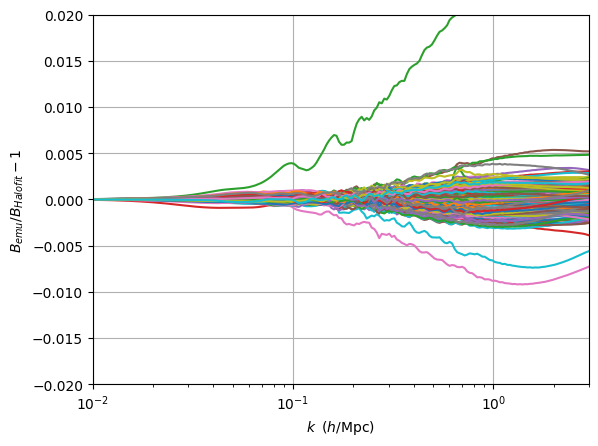

In [82]:
# PC Normalization 2, 1 blocks with 1024
figure, errors = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

In [83]:
figure.savefig("11pcs_norm2.pdf")

Number of cosmologies with error > 0.005: 8 out of 300


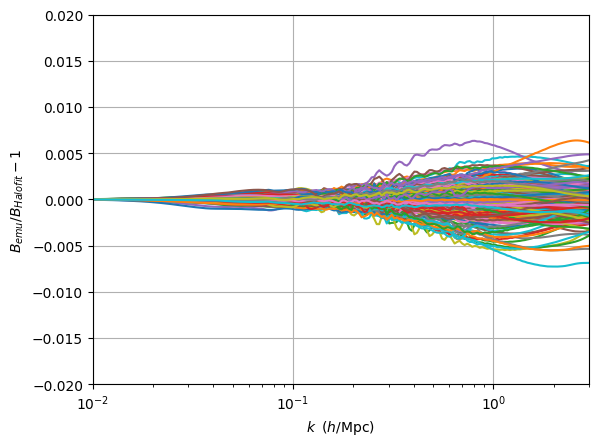

In [35]:
# PC Normalization 2
figure, errors = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 12 out of 300


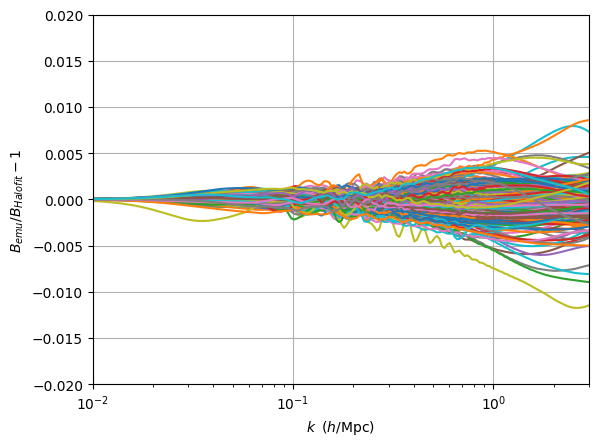

In [19]:
resnet = keras.models.load_model(f"models/wcdm/resnet_smear_stretch10_11PCS")
figure, errors = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

In [43]:
figure.suptitle("wCDM Emulation Errors (15PCS)")
figure.savefig("plots/errors_wcdm_15pcs.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 18 out of 300


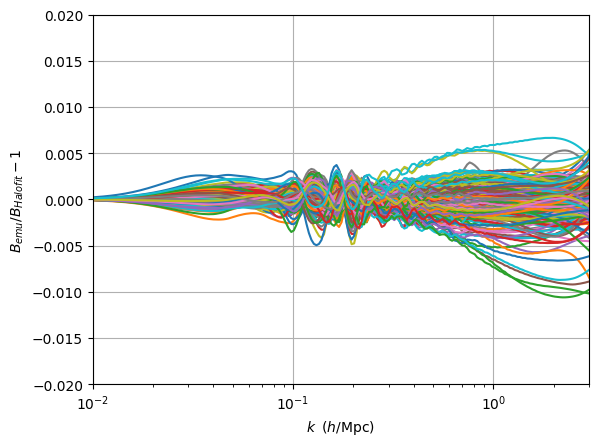

In [30]:
resnet = keras.models.load_model(f"models/wcdm/RESNET_Z0.00_{len(train_samples)}")
figure2, errors2 = evaluate_model(resnet, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 5 out of 300
Number of cosmologies with error > 0.005: 6 out of 300
Number of cosmologies with error > 0.005: 13 out of 300
Number of cosmologies with error > 0.005: 28 out of 300
Number of cosmologies with error > 0.005: 20 out of 300


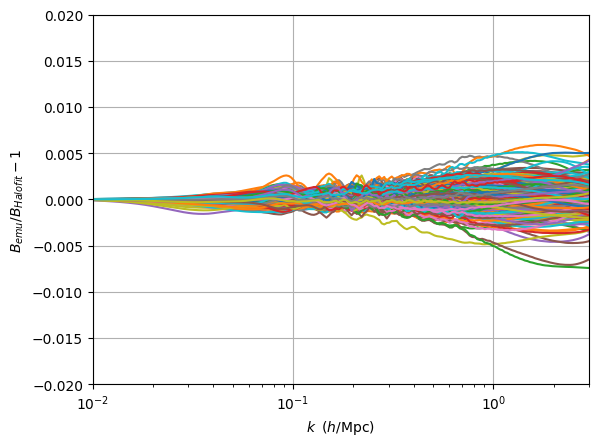

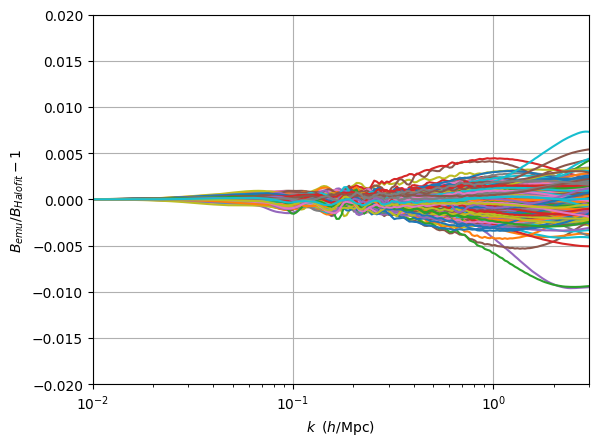

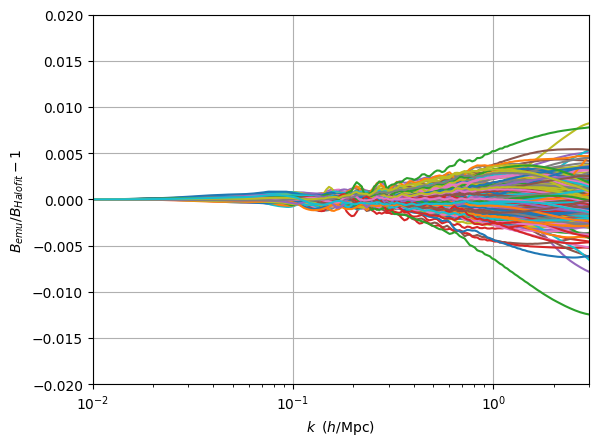

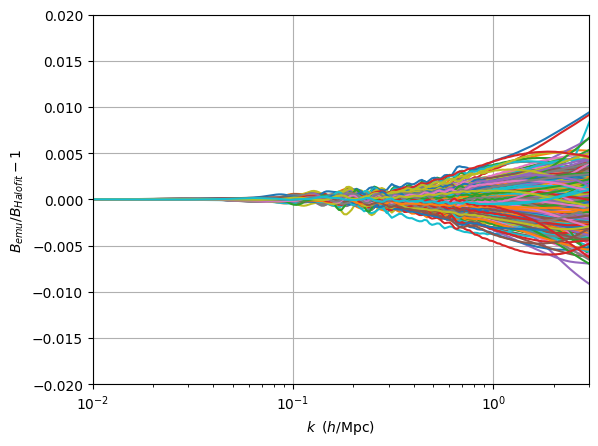

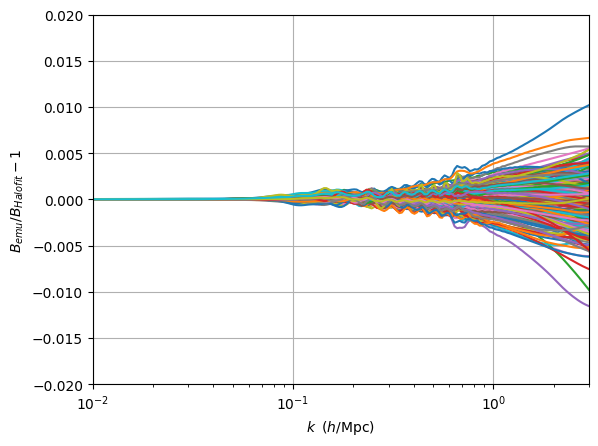

In [20]:
for i, z in enumerate(redshifts):
    resnet = keras.models.load_model(f"models/wcdm/RESNET_Z{z:.2f}_{len(train_samples)}")
    figure, errors = evaluate_model(resnet, test_samples, test_expqs, i, smear=True)
    np.savetxt(f"errors/errors_halofit{len(train_samples)}_nn_z={z:.1f}.txt", errors)

Number of cosmologies with error > 0.005: 2 out of 300
Number of cosmologies with error > 0.005: 3 out of 300
Number of cosmologies with error > 0.005: 3 out of 300
Number of cosmologies with error > 0.005: 8 out of 300
Number of cosmologies with error > 0.005: 10 out of 300


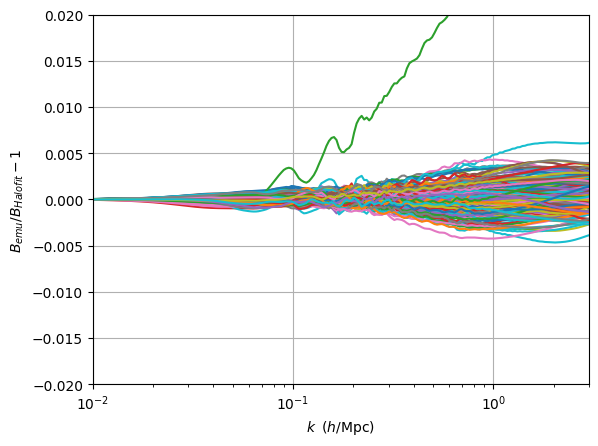

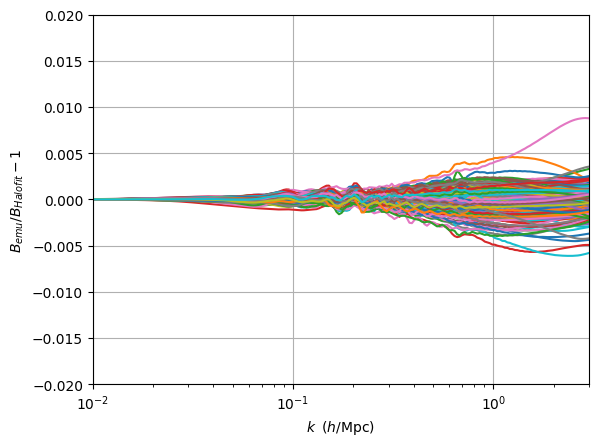

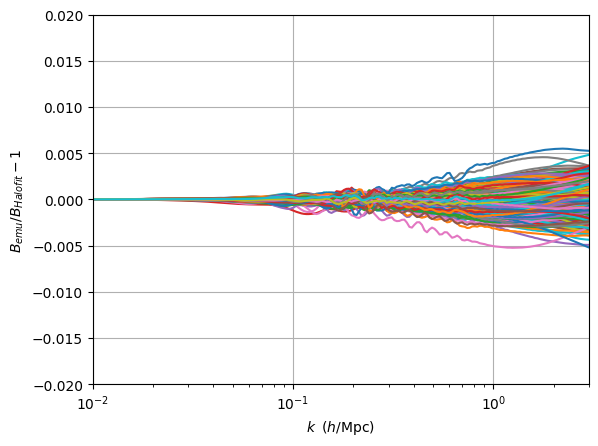

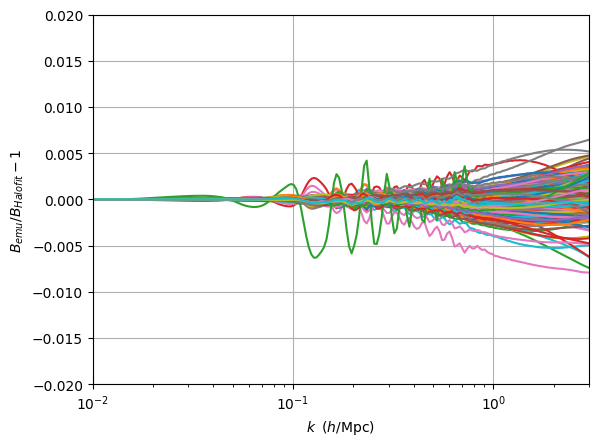

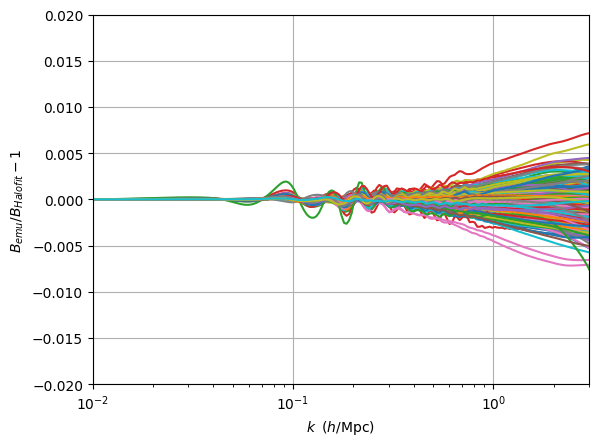

In [20]:
for i, z in enumerate(redshifts):
    resnet = keras.models.load_model(f"models/lcdm/RESNET_Z{z:.2f}_{len(train_samples)}")
    figure, errors = evaluate_model(resnet, test_samples, test_expqs, i, smear=True)
    np.savetxt(f"errors/errors_halofit{len(train_samples)}_nn_z={z:.1f}.txt", errors)

Number of cosmologies with error > 0.005: 8 out of 300


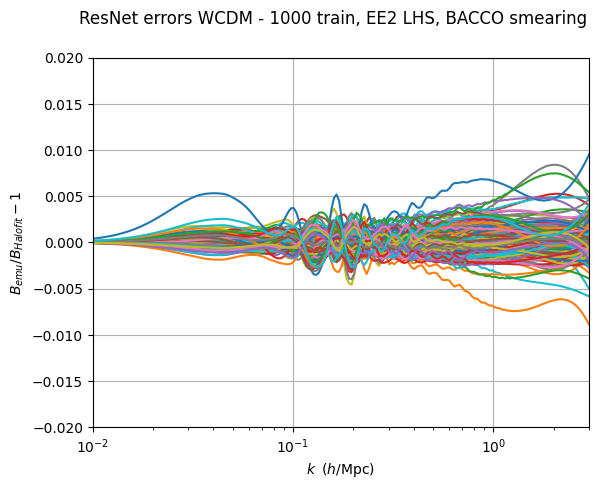

In [78]:
resnet_smeared = keras.models.load_model("models/wcdm/resnet_smear_stretch10_1kpts")
figure, errors = evaluate_model(resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle(f"ResNet errors {model.upper()} - {len(train_samples)} train, EE2 LHS, BACCO smearing")
figure.savefig("plots/resnet_smeared_errors_wcdm_stretch10_1kpts.pdf", bbox_inches="tight")

In [83]:
np.amax(np.abs(errors))

0.010367110335961272

Number of cosmologies with error > 0.005: 8 out of 300


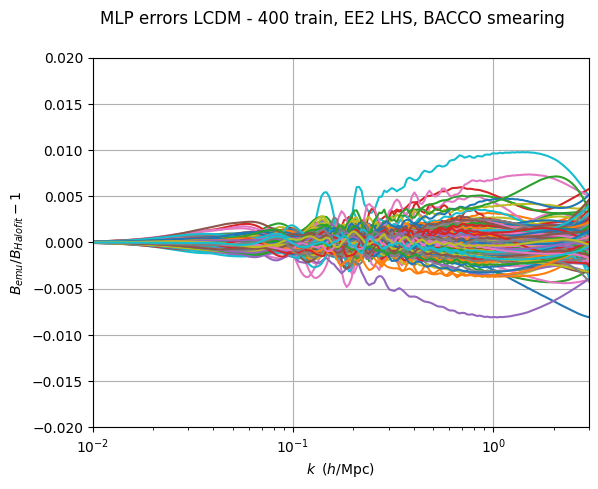

In [70]:
mlp_smeared = keras.models.load_model("models/mlp_smear")
figure = evaluate_model(mlp_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors.pdf", bbox_inches="tight")

Cosmology 9 in test sample is weird
Number of cosmologies with error > 0.005: 4 out of 300


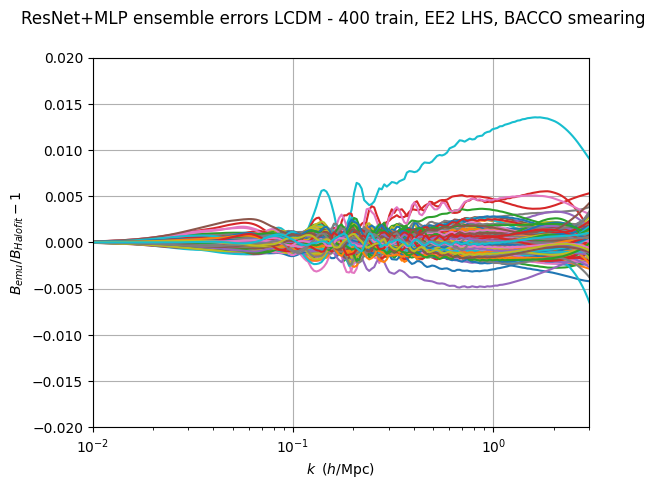

In [71]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_ensemble(mlp_smeared, resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, EE2 LHS, BACCO smearing")
figure.savefig("plots/ensemble_errors.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 1 out of 300


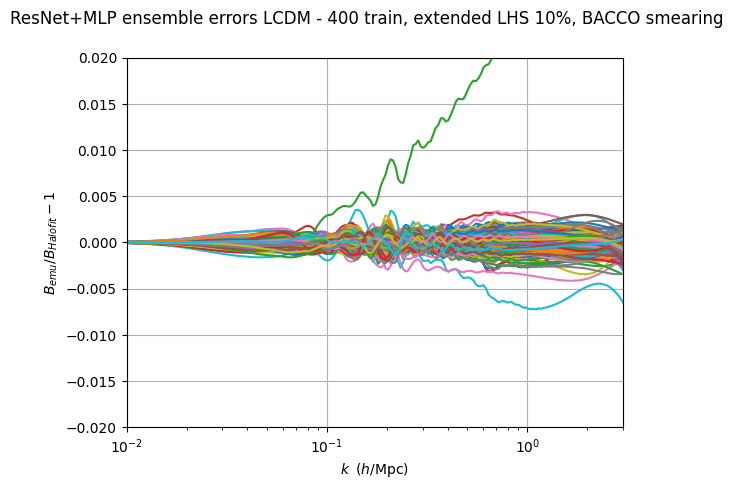

In [36]:
figure = evaluate_ensemble(mlp_smeared_stretch10, resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/ensemble.pdf", bbox_inches="tight")

Cosmology 252 in test sample is weird
Number of cosmologies with error > 0.005: 3 out of 300


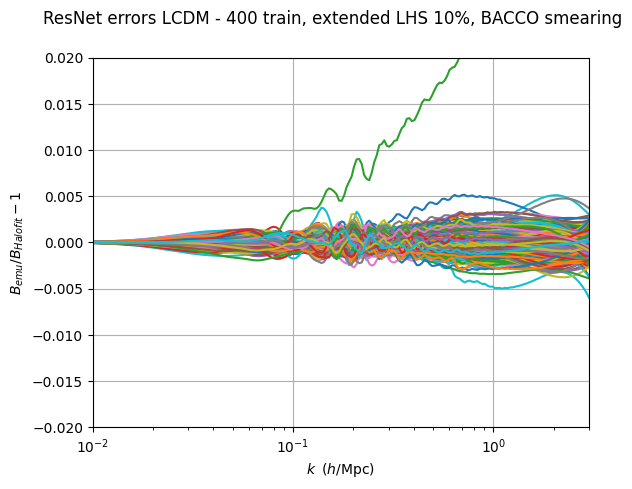

In [32]:
resnet_smeared_stretch10 = keras.models.load_model("models/resnet_smear_stretch10")
figure = evaluate_model(resnet_smeared_stretch10, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 10%, BACCO smearing")
figure.savefig("plots/resnet_smeared_errors_stretchLHS10.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


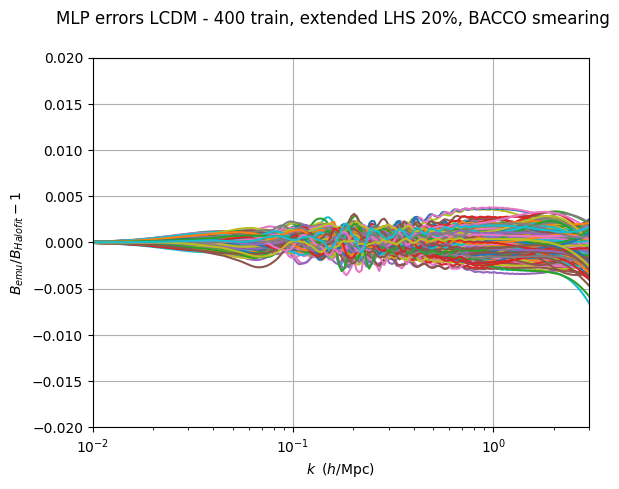

In [52]:
mlp_smeared_stretch20 = keras.models.load_model("models/mlp_smear_stretch20")
figure = evaluate_model(mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("MLP errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("plots/mlp_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 1 out of 300


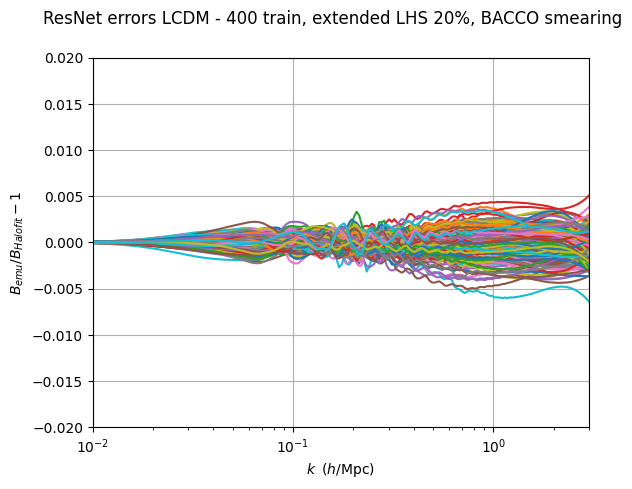

In [53]:
resnet_smeared_stretch20 = keras.models.load_model("models/resnet_smear_stretch20")
figure = evaluate_model(resnet_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("resnet_smeared_errors_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 0 out of 300


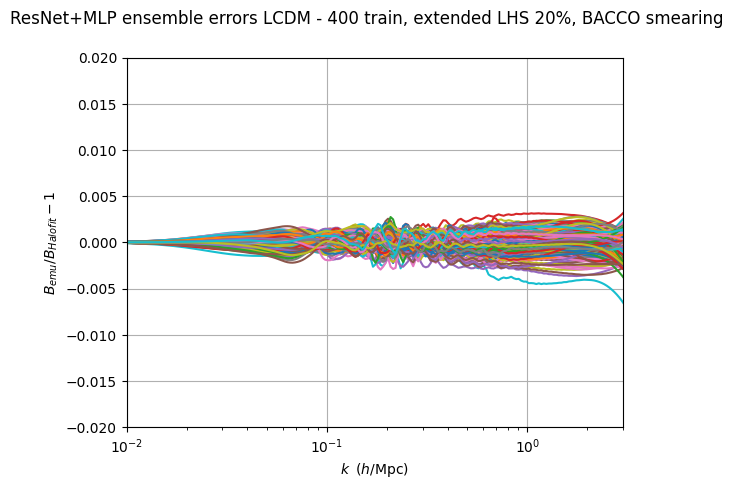

In [54]:
figure = evaluate_ensemble(resnet_smeared_stretch20, mlp_smeared_stretch20, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet+MLP ensemble errors LCDM - 400 train, extended LHS 20%, BACCO smearing")
figure.savefig("ensemble_stretchLHS20.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 4 out of 300


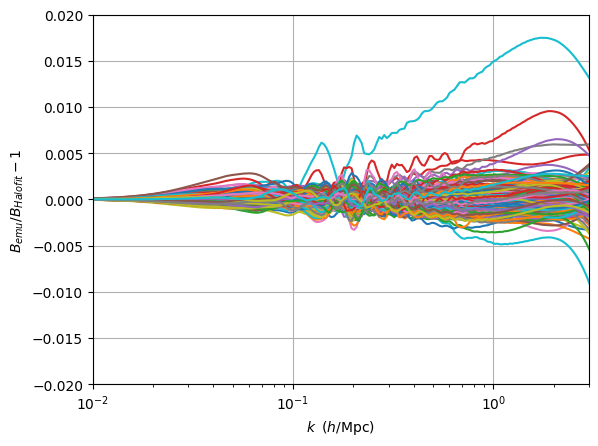

In [65]:
resnet_smeared = keras.models.load_model("models/resnet_smear")
figure = evaluate_model(resnet_smeared, test_samples, test_expqs, 0, smear=True)
figure.suptitle("ResNet errors - 400 train, BACCO smearing")
figure.savefig("resnet_smeared_errors.pdf", bbox_inches="tight")

Number of cosmologies with error > 0.005: 23 out of 300


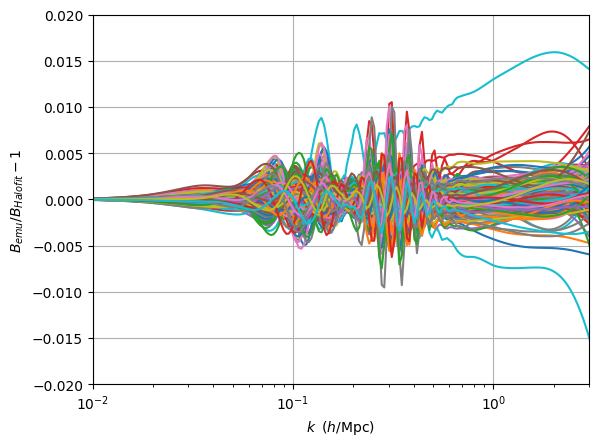

In [74]:
resnet_no_smear = keras.models.load_model("models/resnet_nosmear")
figure = evaluate_model(resnet_no_smear, test_samples, test_boosts, 0, smear=False)
figure.suptitle("ResNet errors - 400 train, no smearing")
figure.savefig("resnet_nosmear_errors.pdf", bbox_inches="tight")